**This is the implementation of CNN from scratch.**

The model is used for recognizing handwriten digit.

The notebook contains:
- Problem statement.
- Model architecture selection (number of layers, activation functions, loss functions, ...).
- Model evaluation.

**Problem statement: Recognize handwriten digits.**

Dataset: MNIST Dataset

MNIST stands for Modified National Institute of Standards and Technology dataset.

It is a benchmark dataset in machine learning and computer vision, commonly used for training and testing image classification models.

It contains 70,000 grayscale 28 × 28 pixels images of handwritten digits, including 60,000 for training and 10,000 for testing.

Input:
- Picture of a handwriten digit, from 0 to 9.

Output:
- The digit in the picture, from 0 to 9.

**Model architecture selection**

**Input Layer**
- 784 neurons capture 28 x 28 pixels.

**Hidden Layer**
- 1 layer, 10 neurons.
- Activation function: ReLU.

**Output Layer**
- 9 neurons indicate percentage of each digit the image can be.
- Activation function: Softmax.
- Cost function: Cross Entropy.

In [137]:
# Import libraries
import numpy as np
import pandas as pd
import struct
import os
import random
import matplotlib.pyplot as plt

from array import array
from os.path import join

In [138]:
#
# Set file paths based on added MNIST Datasets
#
input_path = '../input/mnist-dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    
    def __init__(
        self,
        training_images_filepath,
        training_labels_filepath,
        test_images_filepath,
        test_labels_filepath,
    ):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, "rb") as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    "Magic number mismatch, expected 2049, got {}".format(magic)
                )
            labels = array("B", file.read())

        with open(images_filepath, "rb") as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    "Magic number mismatch, expected 2051, got {}".format(magic)
                )
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols : (i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath
        )
        x_test, y_test = self.read_images_labels(
            self.test_images_filepath, self.test_labels_filepath
        )
        
        return (x_train, y_train), (x_test, y_test)


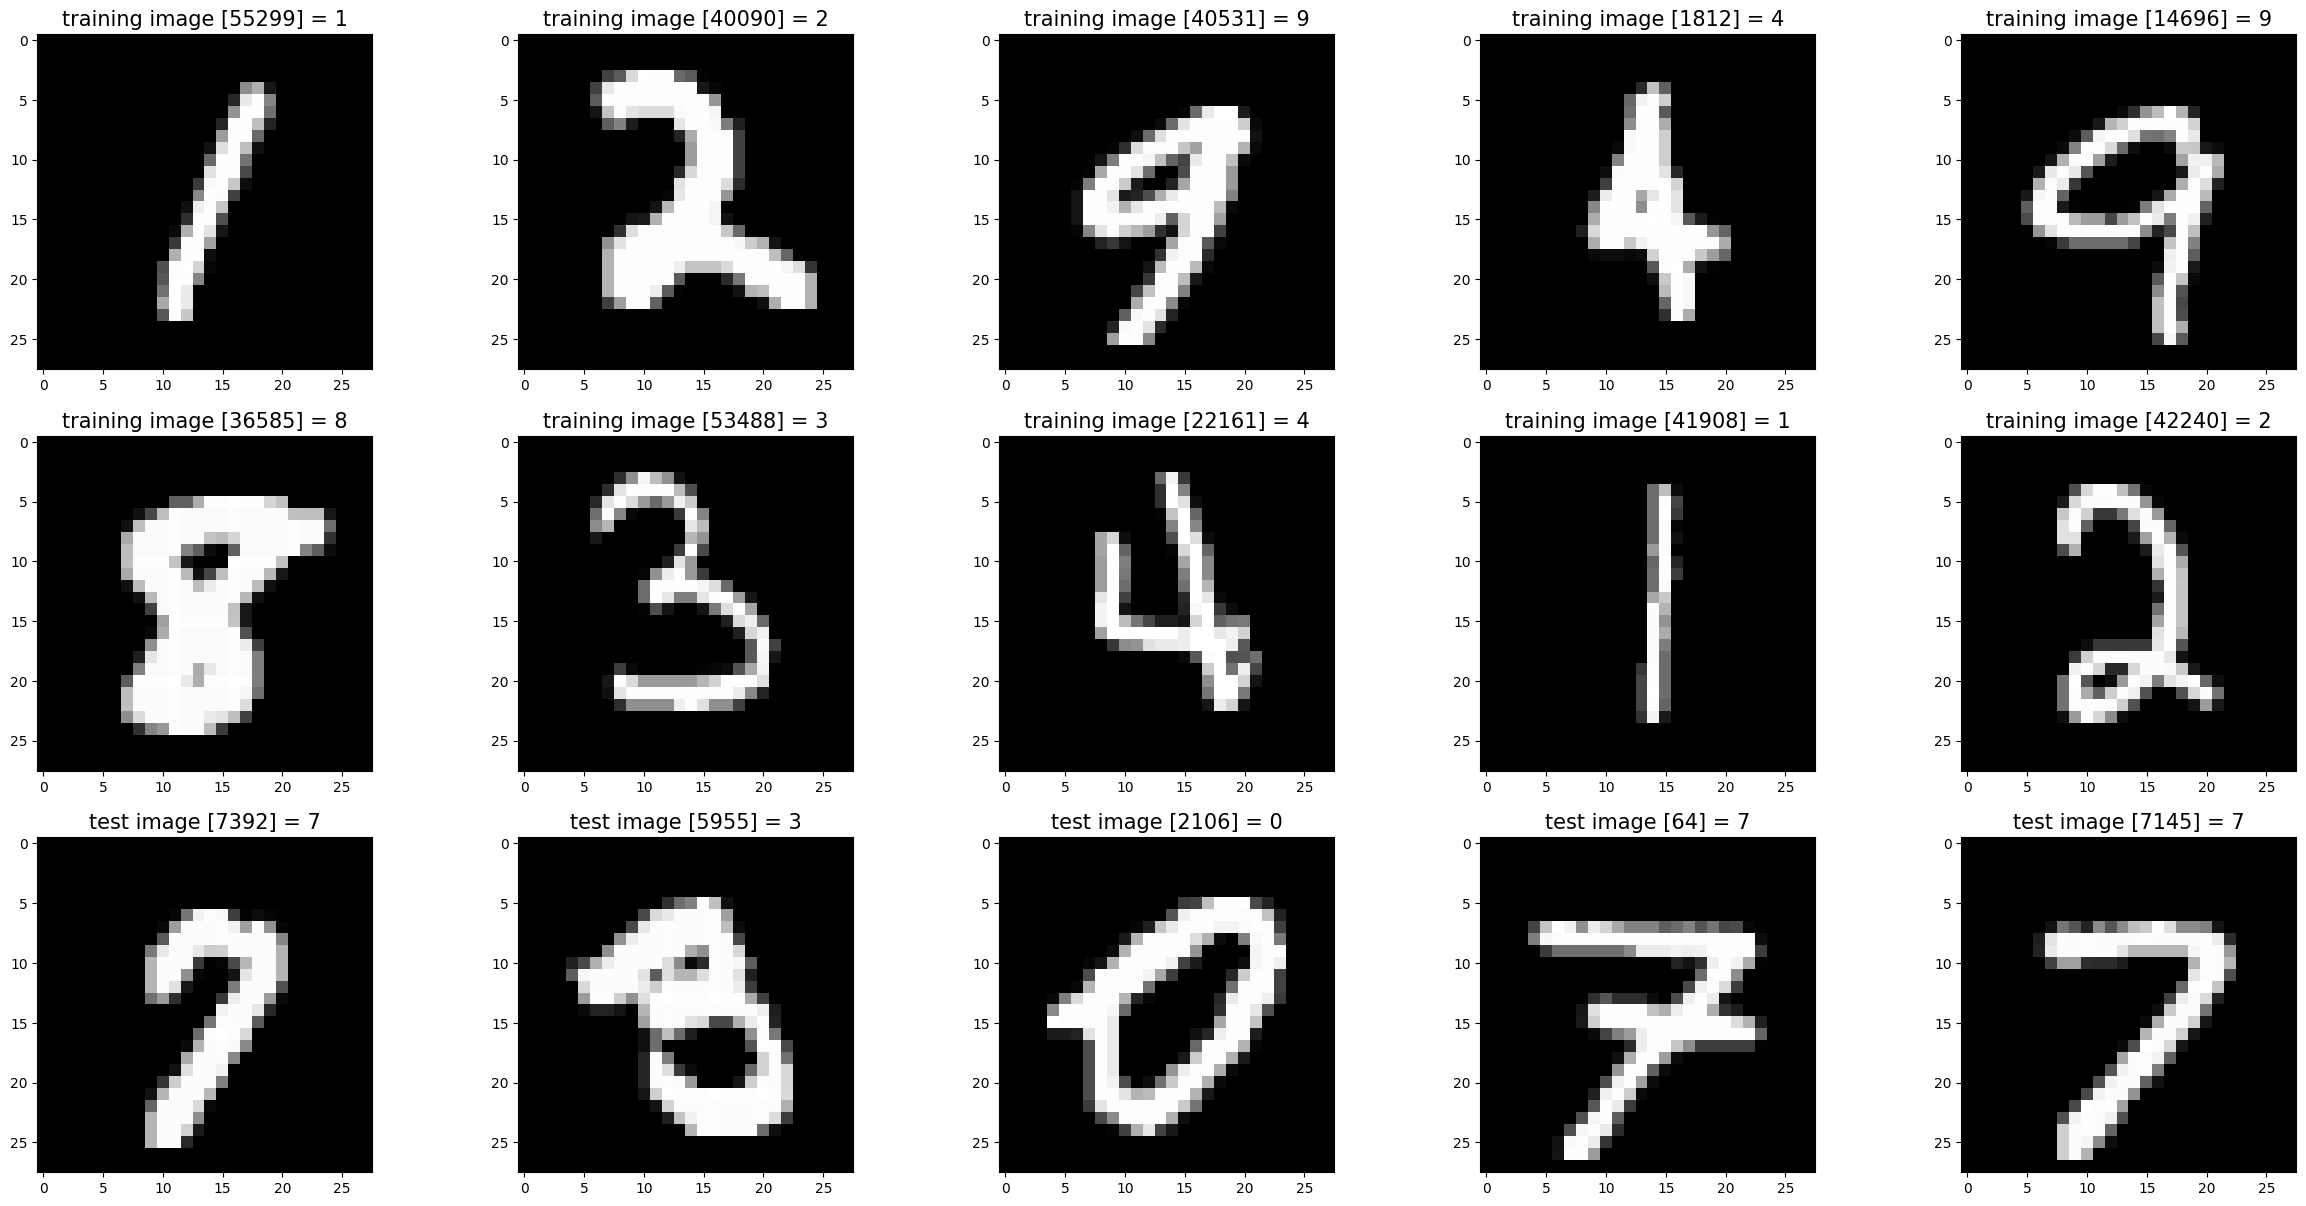

In [139]:
# Testing
dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)


In [140]:
# Pre processing data from [n x 28 x 28] to [n x 784]
x_train = np.array(x_train)
# print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1)
# print(x_train.shape)
x_train = x_train.T
# print(x_train.shape)
x_train = x_train / 255

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test.T
x_test = x_test / 255

y_train = np.array(y_train)
y_test = np.array(y_test)

In [141]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_train.size)

(784, 60000) (60000,)
(784, 10000) (10000,)
60000


In [142]:
def one_hot_encode(y):
    encode = np.zeros((y.size, y.max() + 1))
    encode[np.arange(y.size), y] = 1
    return encode.T

def relu(z):
    return np.maximum(z, 0)

def relu_derivative(z):
    return z > 0

def softmax(z):
    return np.exp(z) / sum(np.exp(z))

# Init params
def init_params():

    # Init weights and biases for first hidden layer
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5

    # Init weights and biases for output layer
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return w1, b1, w2, b2

# Perform forward propagation
def forward_propagation(w1, b1, w2, b2, x):

    # Calculate weighted sum for input of hidden layer
    z1 = w1.dot(x) + b1
    # Apply activation function: ReLU
    a1 = relu(z1)

    # Calculate weighted sum for input of output layer
    z2 = w2.dot(a1) + b2
    # Apply activation function: Softmax
    a2 = softmax(z2)

    return z1, a1, z2, a2

def backward_propagation(z1, a1, z2, a2, w2, x, y):
    y_one_hot_encode = one_hot_encode(y)
    sample_number = y.size

    # Calculate derivative of cross entropy with the respect of:
    # - b2
    # - w2
    # - b1
    # - w1
    derivative_cross_entropy_respect_z2 = a2 - y_one_hot_encode
    
    derivative_cross_entropy_respect_b2 = (1 / sample_number) * np.sum(derivative_cross_entropy_respect_z2)
    derivative_cross_entropy_respect_w2 = (1 / sample_number) * derivative_cross_entropy_respect_z2.dot(a1.T)
    
    derivative_cross_entropy_respect_z1 = w2.T.dot(derivative_cross_entropy_respect_z2) * relu_derivative(z1)
    
    derivative_cross_entropy_respect_b1 = (1 / sample_number) * np.sum(derivative_cross_entropy_respect_z1)
    derivative_cross_entropy_respect_w1 = (1 / sample_number) * derivative_cross_entropy_respect_z1.dot(x.T)
    
    return derivative_cross_entropy_respect_w1, derivative_cross_entropy_respect_b1, derivative_cross_entropy_respect_w2, derivative_cross_entropy_respect_b2

def update_parameters(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate):
    w1 = w1 - dw1 * learning_rate
    b1 = b1 - db1 * learning_rate
    w2 = w2 - dw2 * learning_rate
    b2 = b2 - db2 * learning_rate
    return w1, b1, w2, b2
    
    

In [145]:
def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size

def gradient_descent(x, y, epoches, learning_rate):
    w1, b1, w2, b2 = init_params()
    for i in range(epoches):
        z1, a1, z2, a2 = forward_propagation(w1, b1, w2, b2, x)
        dw1, db1, dw2, db2 = backward_propagation(z1, a1, z2, a2, w2, x, y)
        w1, b1, w2, b2 = update_parameters(w1, b1, w2, b2, dw1, db1, dw2, db2, learning_rate)
        if i % 10 == 0:
            print("Training...")
            predictions =  get_predictions(a2)
            print("Accuracy: ", get_accuracy(predictions, y))

    return w1, b1, w2, b2

In [146]:
w1, b1, w2, b2 = gradient_descent(x_train, y_train, 500, 0.1)

Training...
[6 6 0 ... 0 3 8] [5 0 4 ... 5 6 8]
Accuracy:  0.13701666666666668
Training...
[6 6 4 ... 9 3 8] [5 0 4 ... 5 6 8]
Accuracy:  0.30893333333333334
Training...
[2 0 4 ... 9 3 8] [5 0 4 ... 5 6 8]
Accuracy:  0.3888333333333333
Training...
[2 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.4549
Training...
[2 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.50905
Training...
[2 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.5551166666666667
Training...
[2 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.5927
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6230833333333333
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6486
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6702666666666667
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.6892
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.70605
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accuracy:  0.7206166666666667
Training...
[5 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Accura

In [153]:
def make_predictions(x, w1, b1, w2, b2):
    _, _, _, a2 = forward_propagation(w1, b1, w2, b2, x)
    predictions = get_predictions(a2)
    return predictions

def test_prediction(index, w1, b1, w2, b2):
    current_image = x_train[:, index, None]
    prediction = make_predictions(x_train[:, index, None], w1, b1, w2, b2)
    label = y_train[index]
    print("Index: ", index)
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Index:  2032
Prediction:  [4]
Label:  4


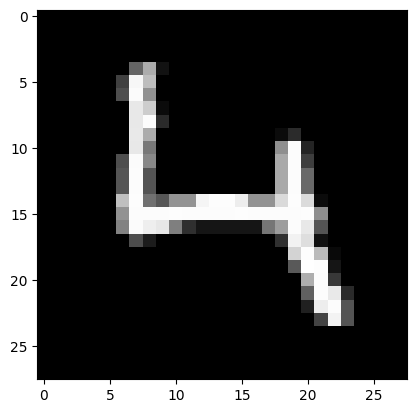

In [154]:
test_prediction(2032, w1, b1, w2, b2)

In [156]:
dev_predictions = make_predictions(x_train, w1, b1, w2, b2)
get_accuracy(dev_predictions, y_train)

[5 0 4 ... 5 0 8] [5 0 4 ... 5 6 8]


0.8562333333333333